https://slowsteadystat.tistory.com/24
https://www.kaggle.com/competitions/tabular-playground-series-mar-2022/data

- train.csv - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.

- row_id - a unique identifier for this instance

- time - the 20-minute period in which each measurement was taken

- x - the east-west midpoint coordinate of the roadway

- y - the north-south midpoint coordinate of the roadway

- direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.

- congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

- test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.

In [1]:
# Load data

import pandas as pd

train = pd.read_csv('./datasets/tabular-playground-series-mar-2022/train.csv')
test = pd.read_csv('./datasets/tabular-playground-series-mar-2022/test.csv')

train.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [2]:
test.head()

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB


# EDA

<Axes: xlabel='direction', ylabel='count'>

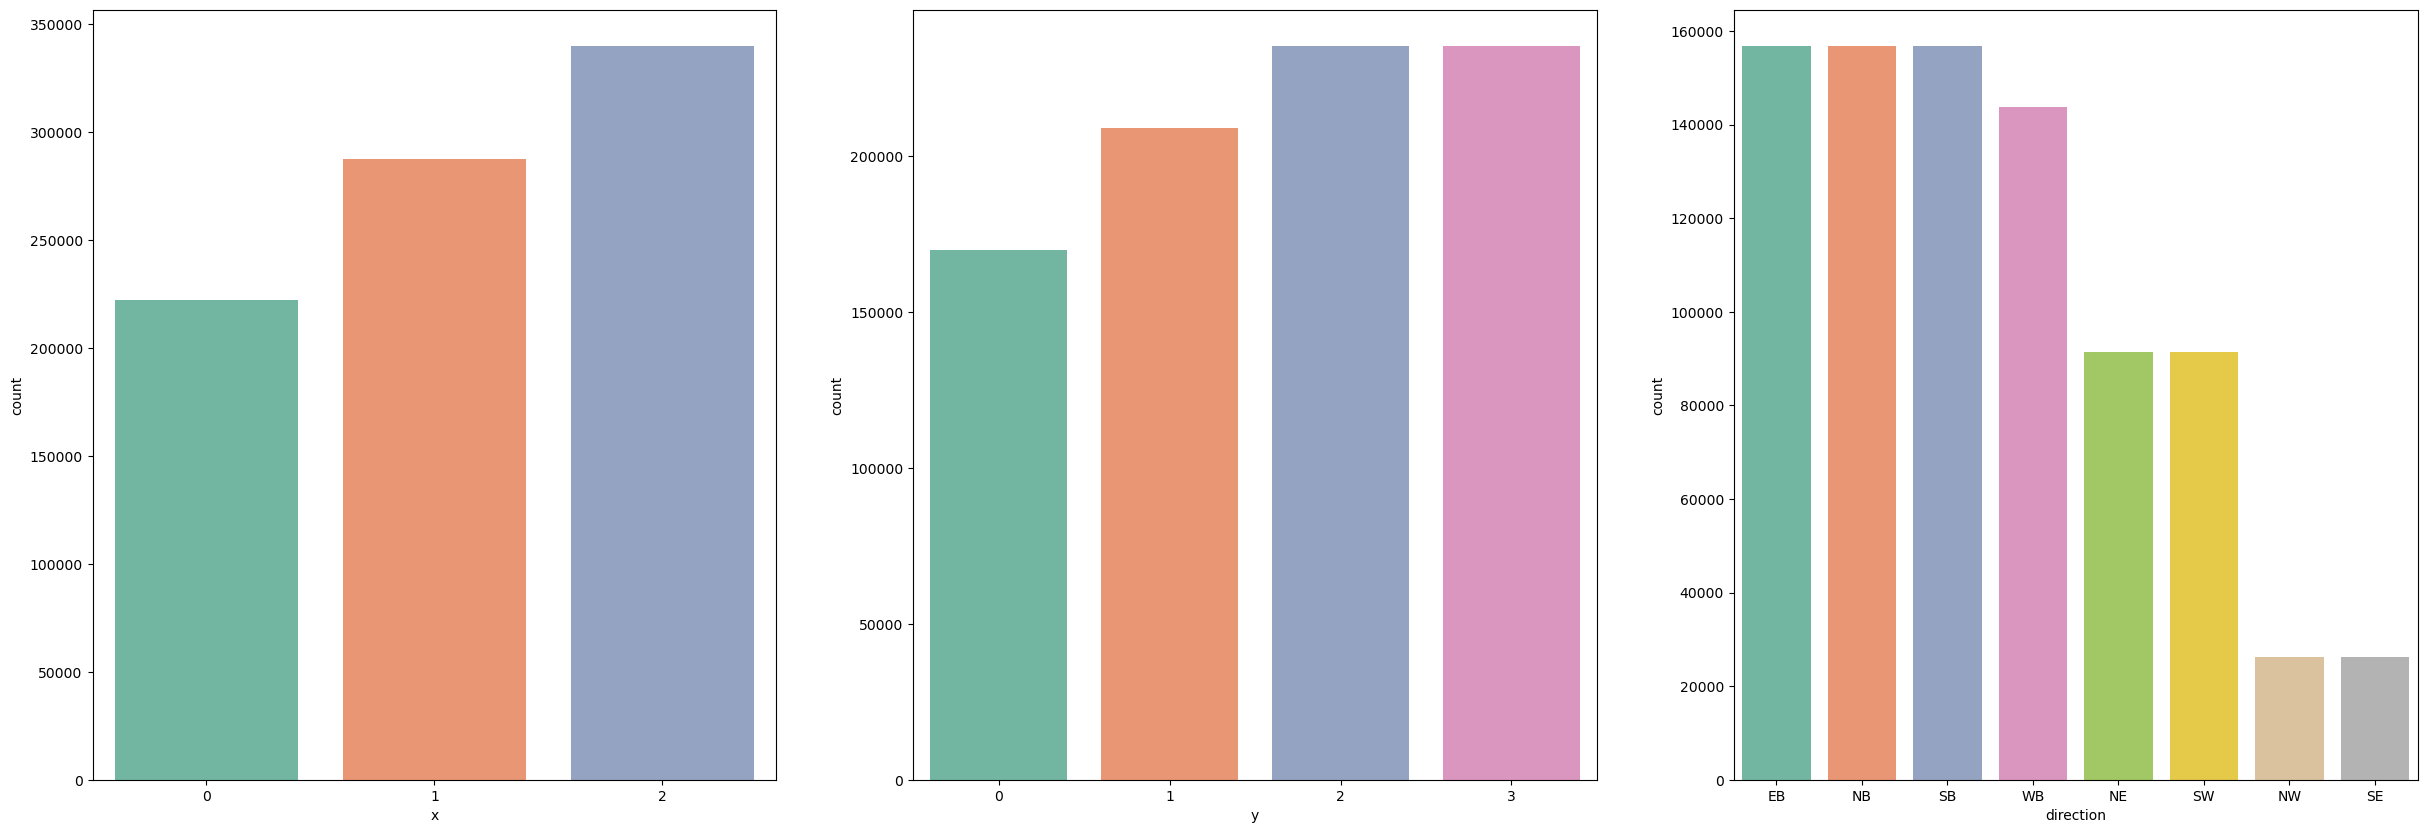

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# count plot
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.countplot(data=train, x='x', ax=axes[0], palette='Set2')
sns.countplot(data=train, x='y', ax=axes[1], palette='Set2')
sns.countplot(data=train, x='direction', ax=axes[2], palette='Set2')

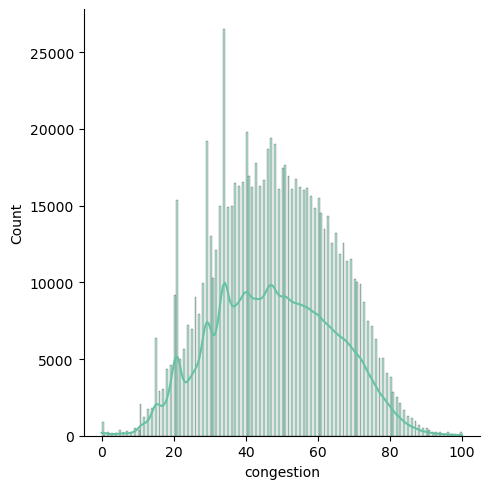

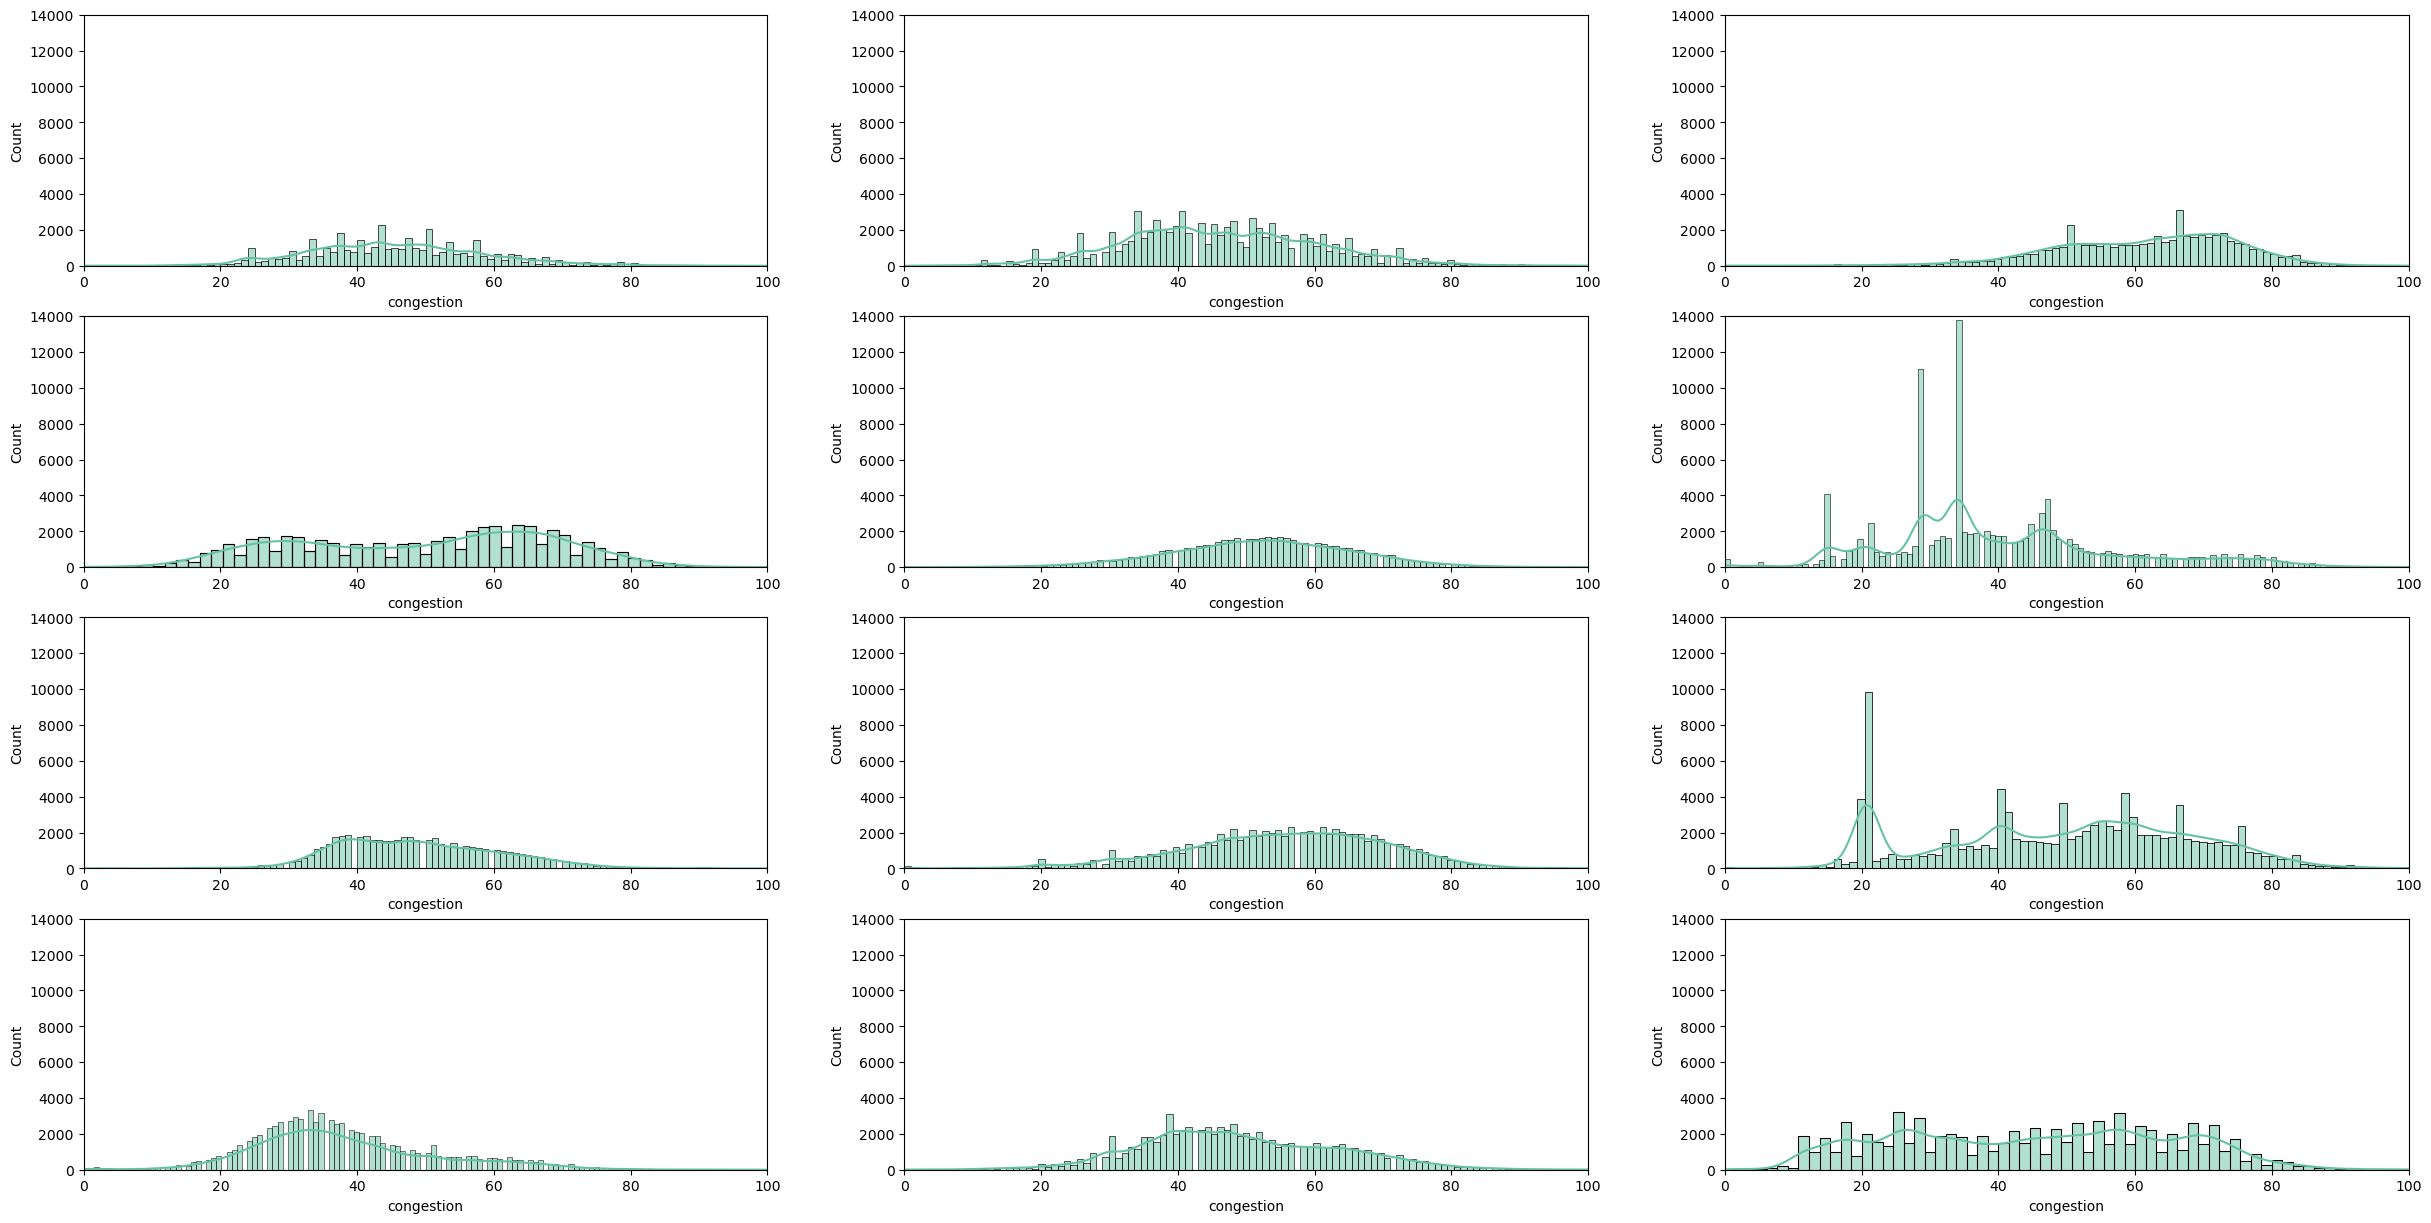

In [4]:
# displot
sns.displot(train.congestion, kind='hist', kde=True, color=sns.color_palette('Set2')[0])

# display by condition
fig, axes = plt.subplots(4, 3, figsize=(30, 15))
plt.setp(axes, xlim=(0, 100), ylim=(0, 14000))
for i in range(3):
    for j in range(4):
        sns.histplot(train[(train.x==i)&(train.y==j)].congestion, kde=True, ax=axes[j][i], color=sns.color_palette('Set2')[0])

<Axes: xlabel='direction', ylabel='congestion'>

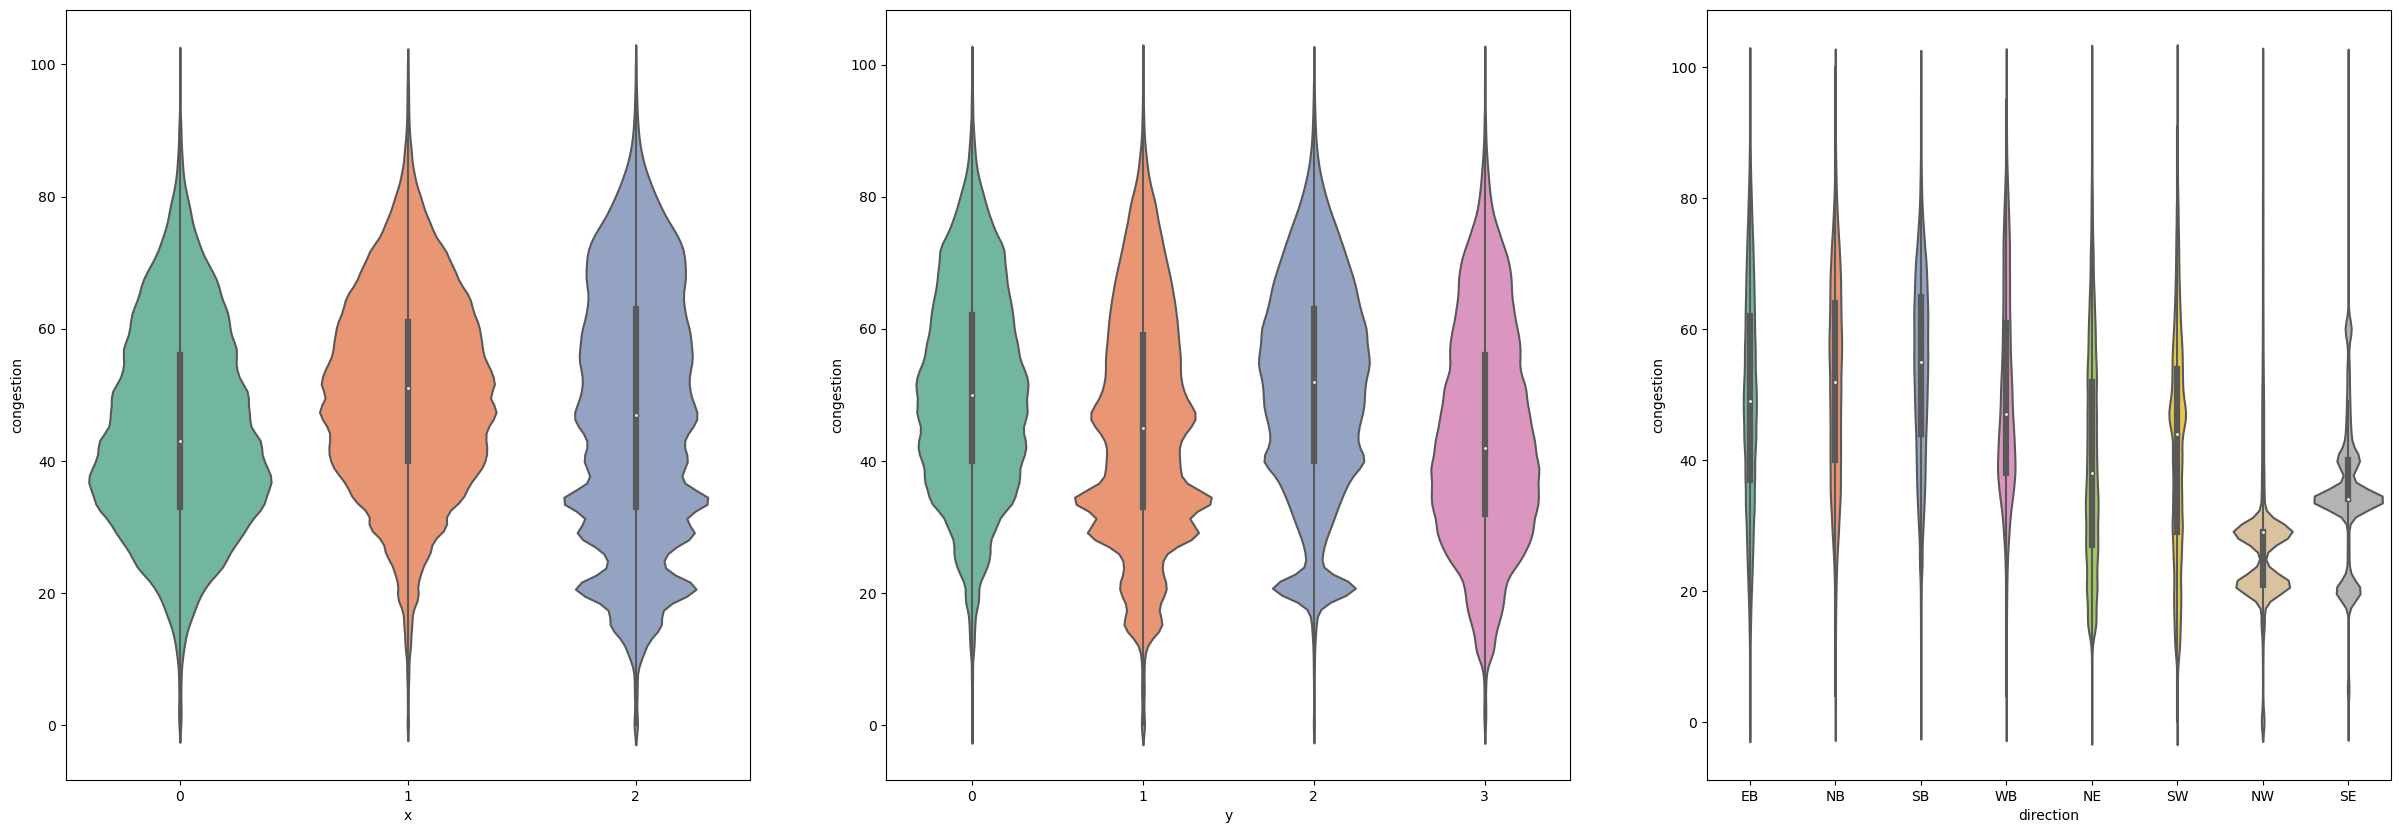

In [5]:
# vilolinplot
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.violinplot(x='x', y='congestion', data=train, ax=axes[0], palette='Set2')
sns.violinplot(x='y', y='congestion', data=train, ax=axes[1], palette='Set2')
sns.violinplot(x='direction', y='congestion', data=train, ax=axes[2], palette='Set2')

# Feature Engineeing

In [6]:
import holidays
us_holidays = holidays.US()

# generate holiday table
holiday_df = pd.DataFrame(columns=['ds', 'holiday_yn'])
holiday_df['ds'] = sorted(train['time'])
holiday_df['holiday_yn'] = holiday_df.ds.apply(lambda x: 1.0 if x in us_holidays else 0.0)
holiday_df.describe()

,holiday_yn
count,848835.000000
mean,0.016540
std,0.127541
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
import numpy as np

dir_mapper = {
    'EB' : [1, 0],
    'NB' : [0, 1],
    'SB' : [0, -1],
    'WB' : [-1, 0],
    'NE' : [1, 1],
    'SW' : [-1, -1],
    'NW' : [-1, 1],
    'SE' : [1, -1]
}

def feature_engineering(data):
    data['time'] = pd.to_datetime(data['time'])
    data['month'] = data['time'].dt.month
    data['weekday'] = data['time'].dt.weekday
    data['hour'] = data['time'].dt.hour
    data['minute'] = data['time'].dt.minute
    # data['holiday_yn'] = np.where(data.time.dt.date.isin(us_holidays), 1.0).astype('str')
    data['holiday_yn'] = data.time.apply(lambda x: "1" if x in us_holidays else "0")
    data['converted_direction_coord_0'] = data['direction'].map(lambda x: dir_mapper[x][0])
    data['converted_direction_coord_1'] = data['direction'].map(lambda x: dir_mapper[x][1])
    data['is_month_start'] = data['time'].dt.is_month_start.astype('int')
    data['is_month_end'] = data['time'].dt.is_month_end.astype('int')
    data['is_weekend'] = (data['time'].dt.dayofweek > 4).astype('int')
    data['is_afternoon'] = (data['time'].dt.hour > 12).astype('int')
    data['x+y'] = data['x'].astype('str') + data['y'].astype('str')
    data['x+y+direction'] = data['x'].astype('str') + data['y'].astype('str') + data['direction'].astype('str')
    data['x+y+direction0'] = data['x'].astype('str') + data['y'].astype('str') + data['converted_direction_coord_0'].astype('str')
    data['x+y+direction1'] = data['x'].astype('str') + data['y'].astype('str') + data['converted_direction_coord_1'].astype('str')
    data['hour+direction'] = data['hour'].astype('str') + data['direction'].astype('str')
    data['hour+x+y'] = data['hour'].astype('str') + data['x'].astype('str') + data['y'].astype('str')
    data['hour+direction+x'] = data['hour'].astype('str') + data['direction'].astype('str') + data['x'].astype('str')
    data['hour+direction+y'] = data['hour'].astype('str') + data['direction'].astype('str') + data['y'].astype('str')
    data['hour+direction+x+y'] = data['hour'].astype('str') + data['direction'].astype('str') + data['x'].astype('str') + data['y'].astype('str')
    data['hour+x'] = data['hour'].astype('str') + data['x'].astype('str')
    data['hour+y'] = data['hour'].astype('str') + data['y'].astype('str')

for data in [train, test]:
    feature_engineering(data)

In [8]:
train.head()

,row_id,time,x,y,direction,congestion,month,weekday,hour,minute,...,x+y+direction,x+y+direction0,x+y+direction1,hour+direction,hour+x+y,hour+direction+x,hour+direction+y,hour+direction+x+y,hour+x,hour+y
0,0,1991-04-01,0,0,EB,70,4,0,0,0,...,00EB,001,000,0EB,000,0EB0,0EB0,0EB00,00,00
1,1,1991-04-01,0,0,NB,49,4,0,0,0,...,00NB,000,001,0NB,000,0NB0,0NB0,0NB00,00,00
2,2,1991-04-01,0,0,SB,24,4,0,0,0,...,00SB,000,00-1,0SB,000,0SB0,0SB0,0SB00,00,00
3,3,1991-04-01,0,1,EB,18,4,0,0,0,...,01EB,011,010,0EB,001,0EB0,0EB1,0EB01,00,01
4,4,1991-04-01,0,1,NB,60,4,0,0,0,...,01NB,010,011,0NB,001,0NB0,0NB1,0NB01,00,01


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   row_id                       848835 non-null  int64         
 1   time                         848835 non-null  datetime64[ns]
 2   x                            848835 non-null  int64         
 3   y                            848835 non-null  int64         
 4   direction                    848835 non-null  object        
 5   congestion                   848835 non-null  int64         
 6   month                        848835 non-null  int64         
 7   weekday                      848835 non-null  int64         
 8   hour                         848835 non-null  int64         
 9   minute                       848835 non-null  int64         
 10  holiday_yn                   848835 non-null  object        
 11  converted_direction_coord_

In [10]:
medians = pd.DataFrame(train.groupby(['x+y+direction', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
print(medians.head())
medians = medians.rename(columns={'congestion':'median'})
print(medians.head())
train = train.merge(medians, on=['x+y+direction', 'weekday', 'hour', 'minute'], how='left')
test = test.merge(medians, on=['x+y+direction', 'weekday', 'hour', 'minute'], how='left')

  x+y+direction  weekday  hour  minute  congestion
0          00EB        0     0       0          35
1          00EB        0     0      20          35
2          00EB        0     0      40          35
3          00EB        0     1       0          35
4          00EB        0     1      20          35
  x+y+direction  weekday  hour  minute  median
0          00EB        0     0       0      35
1          00EB        0     0      20      35
2          00EB        0     0      40      35
3          00EB        0     1       0      35
4          00EB        0     1      20      35


In [11]:
mins = pd.DataFrame(train.groupby(['x+y+direction', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
print(mins.head())
mins = mins.rename(columns={'congestion':'min'})
print(mins.head())
train = train.merge(mins, on=['x+y+direction', 'weekday', 'hour', 'minute'], how='left')
test = test.merge(mins, on=['x+y+direction', 'weekday', 'hour', 'minute'], how='left')


  x+y+direction  weekday  hour  minute  congestion
0          00EB        0     0       0          30
1          00EB        0     0      20          30
2          00EB        0     0      40          30
3          00EB        0     1       0          30
4          00EB        0     1      20          30
  x+y+direction  weekday  hour  minute  min
0          00EB        0     0       0   30
1          00EB        0     0      20   30
2          00EB        0     0      40   30
3          00EB        0     1       0   30
4          00EB        0     1      20   30


In [12]:
maxs = pd.DataFrame(train.groupby(['x+y+direction', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
train = train.merge(maxs, on=['x+y+direction', 'weekday', 'hour', 'minute'], how='left')
test = test.merge(maxs, on=['x+y+direction', 'weekday', 'hour', 'minute'], how='left')

# Temporal Fusion Transformer

TFT 모델 피팅을 위해서는 time_id를 만들어줘야 합니다.

In [13]:
train['time_id'] = (((train.time.dt.dayofyear - 1)*24*60 + train.time.dt.hour*60 + train.time.dt.minute) / 20).astype(int)
test['time_id'] = (((test.time.dt.dayofyear-1)*24*60 + test.time.dt.hour*60 + test.time.dt.minute) / 20).astype(int)
prediction_steps = test['time_id'].nunique()

우리가 예측할 congestion변수 이 외에 static 한 categorical변수와 real변수를 따로 지정하거나 time-varying변수도 추가로 지정하여 모델 학습에 사용합니다.

In [14]:
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9A14AF41-A683-339E-82FD-4A44D9243A2B> /Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there mi

In [15]:
max_prediction_length = 365 # We will predict the entire 2021 year 
max_encoder_length = train.time.nunique()
training_cutoff = train["time_id"].max() - max_prediction_length #we will validate on 2020

In [16]:
training = TimeSeriesDataSet(
    train[lambda x: x["time_id"] <= training_cutoff],
    time_idx="time_id", # 시간 인덱스 값
    target="congestion", # target 변수
    group_ids=["x+y+direction"], 
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # list of categorical variables that do not change over time
    static_categoricals=['holiday_yn','x+y', 'x+y+direction', 'x+y+direction0','x+y+direction1'],
    # list of continuous variables that do not change over time
    static_reals=[],
    #  list of categorical variables that change over time and are known in the future
    time_varying_known_categoricals=[
      #  'month', 'weekday', 'hour', 'minute','is_month_start', 'is_month_end', 
      #  'hour+minute', 
      #  'is_weekend', 'is_afternoon',
       'hour+direction', 'hour+x+y', 'hour+direction+x',
       'hour+direction+y', 'hour+direction+x+y', 'hour+x', 'hour+y'],  
    # list of continuous variables that change over time and are known in the future
    time_varying_known_reals=["time_id","min","max",'median'],
    #  list of continuous variables that change over time and are not known in the future. You might want to include your target here.
    time_varying_unknown_reals=["congestion"],    
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True    
 )

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_forecasting/data/timeseries.py:571: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [17]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

optuna가 내재되어 있어 하이퍼파라미터 최적화를 간단하게 진행할 수 있습니다.

In [21]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study optuna
study = optimize_hyperparameters(
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    model_path='optuna_test',
    n_trials=50,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 64),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.1, 0.3),
    # trainer_kwargs=dict(limit_train_batches=30,
    #                     log_every_n_steps=15
    #                     ),
    # reduce_on_plateau__patience=4,
    use_learning_rate_finder=False, # use Optuna to find ideal learning rate or use in-built learning rate finder
    # timeout=5400    # we can increase the timeout for better tuning.
    
)

print(study.best_trial.params)

[I 2023-09-09 23:56:59,553] A new study created in memory with name: no-name-f72b84ef-2518-4392-8dd8-eb46c2eb68fb
/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

NotImplementedError: Support for `training_epoch_end` has been removed in v2.0.0. `TemporalFusionTransformer` implements this method. You can use the `on_train_epoch_end` hook instead. To access outputs, save them in-memory as instance attributes. You can find migration examples in https://github.com/Lightning-AI/lightning/pull/16520.